In [1]:
print('Start import')
import socket 
import strax
import straxen
import numpy as np
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pandas as pd

print(
f'''Working on {socket.getfqdn()} with the following versions 
and installation paths:
strax
\tv{strax.__version__}\t{str(strax.__path__[0])}
straxen
\tv{straxen.__version__}\t{str(straxen.__path__[0])}
''')
from multihist import Hist1d, Histdd
import time
import os
from scipy import stats
from straxen import units
from scipy.ndimage import gaussian_filter1d

Start import
Working on midway2-0416.rcc.local with the following versions 
and installation paths:
strax
	v0.13.9	/dali/lgrandi/strax/strax/strax
straxen
	v0.15.8	/dali/lgrandi/strax/straxen/straxen



In [2]:
st = straxen.contexts.xenonnt_online()

In [3]:
def plot_area_width_aft(events, run_id, low = 0, high = 6, low2 = 0, high2 = 1, binning = 500):
    ph_s1 = Histdd(events['s1_a_area'], events['s1_a_range_50p_area'],
                    bins=(np.logspace(low, high, binning), np.logspace(1, 6, binning)))
    ph_s2 = Histdd(events['s2_a_area'], events['s2_a_range_50p_area'],
                    bins=(np.logspace(low, high, binning), np.logspace(1, 6, binning)))
    phcs1 = Histdd(events['s1_a_area'], events['s1_a_area_fraction_top'],
                    bins=(np.logspace(low, high, binning), np.linspace(0, 1, binning)))
    phcs2 = Histdd(events['s2_a_area'], events['s2_a_area_fraction_top'],
                    bins=(np.logspace(low, high, binning), np.linspace(0, 1, binning)))
    plt.figure(figsize=(12,6))
    ph_s1.plot(log_scale=True, cblabel='S1 events',cmap='plasma')
    ph_s2.plot(log_scale=True, cblabel='S2 events')
    plt.xlabel("peak area (PE)", ha='right', x=1)
    plt.ylabel("peak width 50% (ns)", ha='right', y=1)
    plt.title(f'run {run_id}')
    plt.xscale('log')
    plt.yscale('log')
    plt.figure(figsize=(12,6))
    phcs1.plot(log_scale=True, cblabel='S1 events',cmap='plasma')
    phcs2.plot(log_scale=True, cblabel='S2 events')
    plt.xlabel("peak area (PE)", ha='right', x=1)
    plt.ylabel("area fraction top", ha='right', y=1)
    plt.title(f'run {run_id}')
    plt.xscale('log')

In [4]:
def mask_KrSingleS1(df):
    def line(x):
        return 0.55 * x + 15
    mask = (df['ds_s1_dt'] == 0)
    mask &= (df['s1_a_n_channels'] >= 90) & (df['s1_a_n_channels'] < 225)
    mask &= (line(df['s1_a_area']) > df['s1_a_n_channels'])
    mask &= (df['s1_a_range_50p_area'] >= 60) & (df['s1_a_range_50p_area'] < 1000)
    mask &= (df['s1_a_area_fraction_top'] < 0.68)
    return mask

In [5]:
def drift_velocity(events, run_id, low = 10, high = 3000, binning = 500, plot=False):
    if 'area_ratio' in events: pass
    else: events.insert(1, 'area_ratio', np.divide(events['cs2_a'],events['cs1_a']))
    events = events[events['area_ratio']<1e3]
    
    # cathode drop-off
    dt = np.linspace(low, high, binning)
    hdtime = Hist1d(events['drift_time']/1e3, bins=dt)
    nstep = 20
    step = np.concatenate((np.full(nstep,-1), np.full(2*nstep,1),np.full(nstep,-1)))
    conv = np.convolve(hdtime,step,mode='valid')
    minc = int(np.where(conv==np.min(conv))[0][0])+2*nstep
    maxc = int(np.where(conv==np.max(conv))[0][0])+2*nstep
    dropoff = (dt[minc]+dt[maxc])/2
    dropoff_err = (dt[minc]-dt[maxc])/nstep
    if plot:
        plt.figure(figsize=(12,6))
        hdtime.plot(color='b',label='data')
        plt.ylabel("events", ha='right', y=1)
        plt.xlabel("drift time ($\mu$s)", ha='right', x=1)
        plt.axvline(x=dropoff,linewidth=1,linestyle='-', color='r',label=f'cathode drop-off = {dropoff:.1f} us')
        plt.axvline(x=dropoff+dropoff_err,linewidth=1,linestyle='--', color='r')
        plt.axvline(x=dropoff-dropoff_err,linewidth=1,linestyle='--', color='r')
        plt.legend(fontsize=14)
        
    mh = Histdd(events['drift_time']/1e3, events['area_ratio'],
            bins=(np.linspace(low, high, binning), np.logspace(0, 5, 200)))
    if plot:
        plt.figure(figsize=(12,6))
        mh.plot(log_scale=True, cblabel='events')
        plt.xlabel("drift time ($\mu$s)", ha='right', x=1,fontsize=12)
        plt.ylabel("cS2/cS1", ha='right', y=1,fontsize=12)
        plt.title(f'run {run_id}',fontsize=14)
        plt.yscale('log')
        plt.xlim(1.5e3,high)
        plt.axvline(x=dropoff,linewidth=1,linestyle='-', color='r',label=f'cathode drop-off = {dropoff:.1f} us')
        plt.axvline(x=dropoff+dropoff_err,linewidth=1,linestyle='--', color='r')
        plt.axvline(x=dropoff-dropoff_err,linewidth=1,linestyle='--', color='r')
    
    # gate drift time
    dts = np.linspace(1, 20, 200)
    mh_low = Histdd(events['drift_time']/1e3, events['area_ratio'],
            bins=(dts, np.linspace(0, 200, 200)),axis_names=['drift_time', 'area_ratio'])
    median = mh_low.percentile(50, axis='area_ratio')
    #gatedt = dts[np.where(np.array(median[:int(len(median)/2)])>50)[0][-1]]
    mfilt = gaussian_filter1d(median, 4)
    gatedt = dts[np.where(mfilt<=np.mean(mfilt[100:])+3)[0][0]]
    vd = 1485/(dropoff-gatedt)
    vd_err = vd*(dropoff_err/dropoff)
    if plot:
        plt.figure(figsize=(12,6))
        mh_low.plot(log_scale=False, cblabel='events')
        plt.xlabel("drift time ($\mu$s)", ha='right', x=1,fontsize=12)
        plt.ylabel("cS2/cS1", ha='right', y=1,fontsize=12)
        plt.title(f'run {run_id}',fontsize=14)
        median.plot(color='red',label='median')
        plt.axvline(x=gatedt,linewidth=1,linestyle='--', color='b',label=f'gate drift time = {gatedt:.1f} $\mu$s')
        plt.legend(fontsize=14)
        print(f'Drift velocity = {vd:.3f} +/- {vd_err:.3f} mm/$\mu$s')
    return vd, vd_err

In [6]:
def drift_time_calculation( run_kr, plot = False ):
    run = int(run_kr)
    events = st.get_df(run_kr,'event_info_double',progress_bar=False)
    #if(plot): plot_area_width_aft(events, run_kr)
    mask_singleS1 = mask_KrSingleS1(events)
    #if(plot): plot_area_width_aft(events[mask_singleS1], run_kr)
    e1 = events[mask_singleS1]
    vd, vd_err = drift_velocity(e1, run_kr, plot=plot)
    return run, vd, vd_err

Drift velocity = 0.625 +/- 0.003 mm/$\mu$s


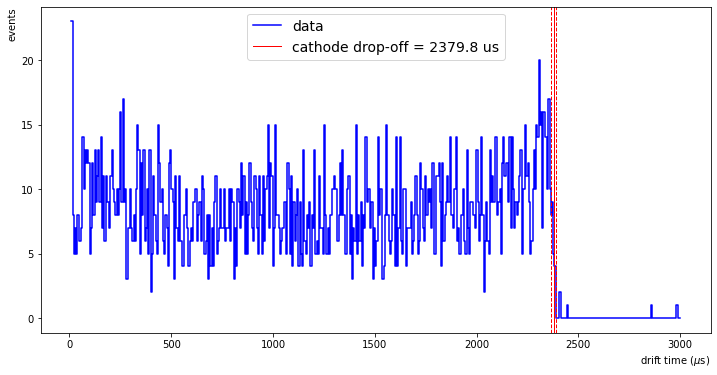

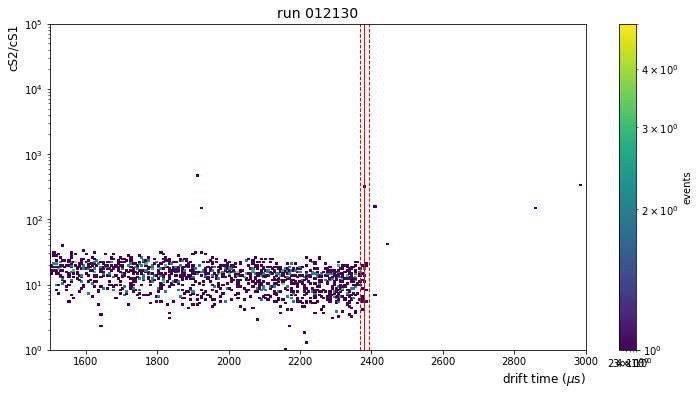

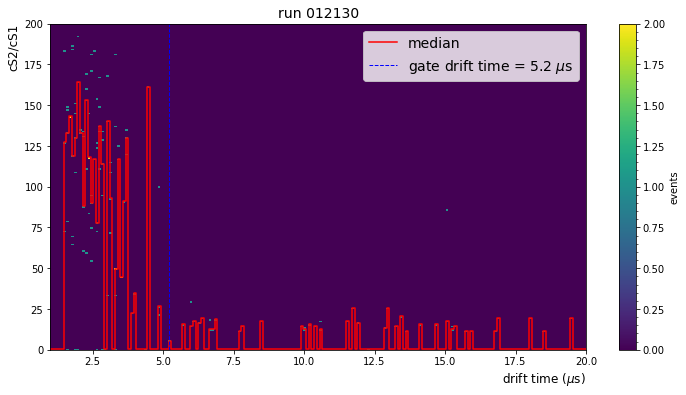

In [10]:
run, vd, vd_err = drift_time_calculation( run_kr = '012130', plot = True)

Drift velocity = 0.629 +/- 0.003 mm/$\mu$s


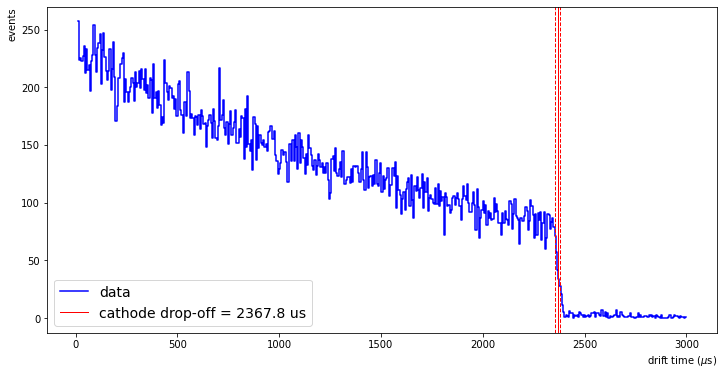

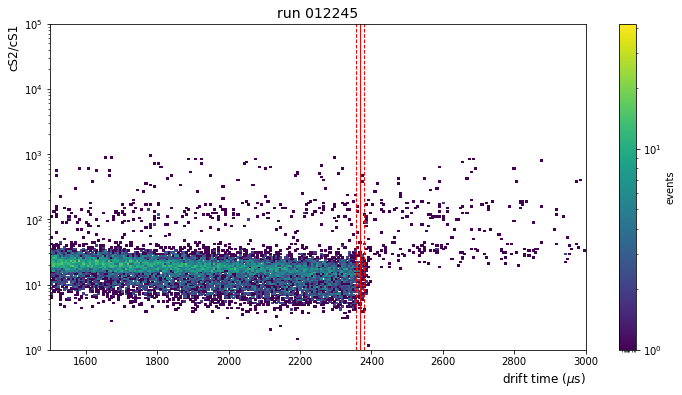

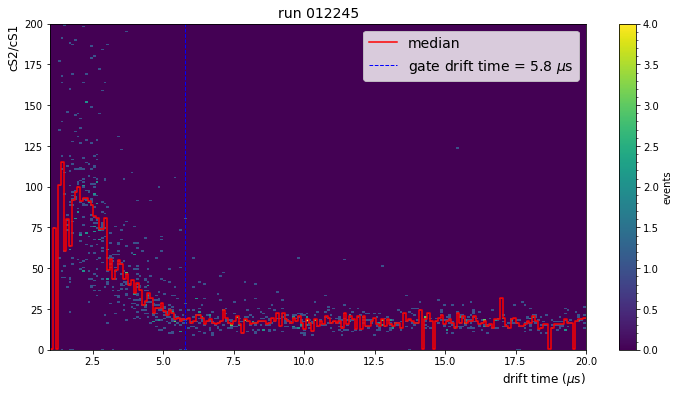

In [11]:
run, vd, vd_err = drift_time_calculation( run_kr = '012245', plot = True)